<a href="https://www.kaggle.com/code/nosanesrine/implementation-of-generative-adversarial-network?scriptVersionId=243097791" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Step1 : Importing the required libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Step 2: Defining a Transform
The code uses PyTorch’s transforms to define a simple picture transforms.Compose. It normalizes and transforms photos into tensors.

In [3]:
# Define a basic transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
print(transform)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


# **Step 3: Loading the Dataset**
A CIFAR-10 dataset is created for training with below code, which also specifies a root directory, turns on train mode, downloads if needed, and applies the specified transform. Subsequently, it generates a 32-batch DataLoader and shuffles the training set of data.

In [5]:
train_dataset = datasets.CIFAR10(root='./data',\
              train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
                                batch_size=32, shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29634148.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# Step 4: Defining parameters to be used in later processes
A Generative Adversarial Network (GAN) is used with specified hyperparameters.

The latent space’s dimensionality is represented by latent_dim.
lr is the optimizer’s learning rate.
The coefficients for the Adam optimizer are beta1 and beta2. To find the total number of training epochs, use num_epochs.

In [6]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10


# Step 5: Defining a Utility Class to Build the Generator
The generator architecture for a GAN in PyTorch is defined with below code.

* From nn.Module, the Generator class inherits. It is comprised of a sequential model with Tanh, linear, convolutional, batch normalization, reshaping, and upsampling layers.
* The neural network synthesizes an image (img) from a latent vector (z), which is the generator’s output.
The architecture uses a series of learned transformations to turn the initial random noise in the latent space into a meaningful image.

In [7]:
# Define the generator
class Generator(nn.Module):
	def __init__(self, latent_dim):
		super(Generator, self).__init__()

		self.model = nn.Sequential(
			nn.Linear(latent_dim, 128 * 8 * 8),
			nn.ReLU(),
			nn.Unflatten(1, (128, 8, 8)),
			nn.Upsample(scale_factor=2),
			nn.Conv2d(128, 128, kernel_size=3, padding=1),
			nn.BatchNorm2d(128, momentum=0.78),
			nn.ReLU(),
			nn.Upsample(scale_factor=2),
			nn.Conv2d(128, 64, kernel_size=3, padding=1),
			nn.BatchNorm2d(64, momentum=0.78),
			nn.ReLU(),
			nn.Conv2d(64, 3, kernel_size=3, padding=1),
			nn.Tanh()
		)

	def forward(self, z):
		img = self.model(z)
		return img


# Step 6: Defining a Utility Class to Build the Discriminator
The PyTorch code describes the discriminator architecture for a GAN. The class Discriminator is descended from nn.Module. It is composed of linear layers, batch normalization, dropout, convolutional, LeakyReLU, and sequential layers.

An image (img) is the discriminator’s input, and its validity—the probability that the input image is real as opposed to artificial—is its output.

In [8]:
# Define the discriminator
class Discriminator(nn.Module):
	def __init__(self):
		super(Discriminator, self).__init__()

		self.model = nn.Sequential(
		nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
		nn.LeakyReLU(0.2),
		nn.Dropout(0.25),
		nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
		nn.ZeroPad2d((0, 1, 0, 1)),
		nn.BatchNorm2d(64, momentum=0.82),
		nn.LeakyReLU(0.25),
		nn.Dropout(0.25),
		nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
		nn.BatchNorm2d(128, momentum=0.82),
		nn.LeakyReLU(0.2),
		nn.Dropout(0.25),
		nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
		nn.BatchNorm2d(256, momentum=0.8),
		nn.LeakyReLU(0.25),
		nn.Dropout(0.25),
		nn.Flatten(),
		nn.Linear(256 * 5 * 5, 1),
		nn.Sigmoid()
	)

	def forward(self, img):
		validity = self.model(img)
		return validity


# Step 7: Building the Generative Adversarial Network
The code snippet defines and initializes a discriminator (Discriminator) and a generator (Generator).

* The designated device (GPU if available) receives both models. Binary Cross Entropy Loss, which is frequently used for GANs, is selected as the loss function (adversarial_loss).
* For the generator (optimizer_G) and discriminator (optimizer_D), distinct Adam optimizers with predetermined learning rates and betas are also defined.

In [9]:
# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
						, lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
						, lr=lr, betas=(beta1, beta2))


**Step 8: Training the Generative Adversarial Network**
For a Generative Adversarial Network (GAN), the code implements the training loop.

The training data batches are iterated through during each epoch. Whereas the generator (optimizer_G) is trained to generate realistic images that trick the discriminator, the discriminator (optimizer_D) is trained to distinguish between real and phony images.
The generator and discriminator’s adversarial losses are computed. Model parameters are updated by means of Adam optimizers and the losses are backpropagated.
Discriminator printing and generator losses are used to track progress. For a visual assessment of the training process, generated images are additionally saved and shown every 10 epochs.

Epoch [1/10]						Batch 100/1563 Discriminator Loss: 0.5646 Generator Loss: 1.0707
Epoch [1/10]						Batch 200/1563 Discriminator Loss: 0.7152 Generator Loss: 0.8949
Epoch [1/10]						Batch 300/1563 Discriminator Loss: 0.5816 Generator Loss: 0.9746
Epoch [1/10]						Batch 400/1563 Discriminator Loss: 0.7328 Generator Loss: 0.9497
Epoch [1/10]						Batch 500/1563 Discriminator Loss: 0.5625 Generator Loss: 1.2444
Epoch [1/10]						Batch 600/1563 Discriminator Loss: 0.6367 Generator Loss: 1.0031
Epoch [1/10]						Batch 700/1563 Discriminator Loss: 0.7054 Generator Loss: 0.8698
Epoch [1/10]						Batch 800/1563 Discriminator Loss: 0.6147 Generator Loss: 0.9014
Epoch [1/10]						Batch 900/1563 Discriminator Loss: 0.6578 Generator Loss: 0.8952
Epoch [1/10]						Batch 1000/1563 Discriminator Loss: 0.5376 Generator Loss: 0.8690
Epoch [1/10]						Batch 1100/1563 Discriminator Loss: 0.5160 Generator Loss: 1.2732
Epoch [1/10]						Batch 1200/1563 Discriminator Loss: 0.6414 Generator Loss: 1.3171
E

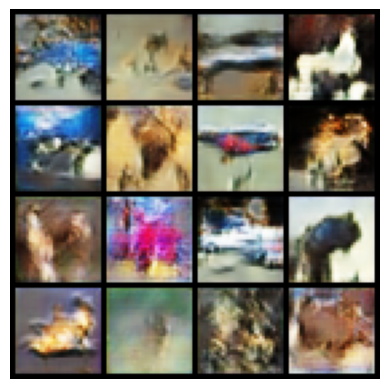

In [10]:
# Training loop
for epoch in range(num_epochs):
	for i, batch in enumerate(dataloader):
	# Convert list to tensor
		real_images = batch[0].to(device) 
		# Adversarial ground truths
		valid = torch.ones(real_images.size(0), 1, device=device)
		fake = torch.zeros(real_images.size(0), 1, device=device)
		# Configure input
		real_images = real_images.to(device)

		# ---------------------
		# Train Discriminator
		# ---------------------
		optimizer_D.zero_grad()
		# Sample noise as generator input
		z = torch.randn(real_images.size(0), latent_dim, device=device)
		# Generate a batch of images
		fake_images = generator(z)

		# Measure discriminator's ability 
		# to classify real and fake images
		real_loss = adversarial_loss(discriminator\
									(real_images), valid)
		fake_loss = adversarial_loss(discriminator\
									(fake_images.detach()), fake)
		d_loss = (real_loss + fake_loss) / 2
		# Backward pass and optimize
		d_loss.backward()
		optimizer_D.step()

		# -----------------
		# Train Generator
		# -----------------

		optimizer_G.zero_grad()
		# Generate a batch of images
		gen_images = generator(z)
		# Adversarial loss
		g_loss = adversarial_loss(discriminator(gen_images), valid)
		# Backward pass and optimize
		g_loss.backward()
		optimizer_G.step()
		# ---------------------
		# Progress Monitoring
		# ---------------------
		if (i + 1) % 100 == 0:
			print(
				f"Epoch [{epoch+1}/{num_epochs}]\
						Batch {i+1}/{len(dataloader)} "
				f"Discriminator Loss: {d_loss.item():.4f} "
				f"Generator Loss: {g_loss.item():.4f}"
			)
	# Save generated images for every epoch
	if (epoch + 1) % 10 == 0:
		with torch.no_grad():
			z = torch.randn(16, latent_dim, device=device)
			generated = generator(z).detach().cpu()
			grid = torchvision.utils.make_grid(generated,\
										nrow=4, normalize=True)
			plt.imshow(np.transpose(grid, (1, 2, 0)))
			plt.axis("off")
			plt.show()
